# Student Name: Huynh Truong Tu
 Below is my assignment for Sprint24's "Sequence to Sequence (Seq2Seq)"

------------------------------------------------------------------------------------------------------------------------------

## Problem 1

In [1]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2021-11-18 23:40:19--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 2606:4700:3030::6815:5c2c, 2606:4700:3033::ac43:ba36, 104.21.92.44, ...
Connecting to www.manythings.org (www.manythings.org)|2606:4700:3030::6815:5c2c|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6451478 (6.2M) [application/zip]
Saving to: 'fra-eng.zip'

     0K .......... .......... .......... .......... ..........  0% 86.4M 0s
    50K .......... .......... .......... .......... ..........  1%  248K 13s
   100K .......... .......... .......... .......... ..........  2% 22.8M 8s
   150K .......... .......... .......... .......... ..........  3%  259K 12s
   200K .......... .......... .......... .......... ..........  3% 6.88M 10s
   250K .......... .......... .......... .......... ..........  4%  626K 10s
   300K .......... .......... .......... .......... ..........  5% 10.7M 8s
   350K .......... .......... .......... .......... .......

In [2]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [2]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 11s 36ms/step - loss: 1.1334 - accuracy: 0.7355 - val_loss: 1.0640 - val_accuracy: 0.7187
Epoch 2/100
125/125 [==============================] - 3s 25ms/step - loss: 0.8167 - accuracy: 0.7783 - val_loss: 0.8428 - val_accuracy: 0.7623
Epoch 3/100
125/125 [==============================] - 3s 25ms/step - loss: 0.6868 - accuracy: 0.8081 - val_loss: 0.7059 - val_accuracy: 0.7954
Epoch 4/100
125/125 [==============================] - 3s 25ms/step - loss: 0.5824 - accuracy: 0.8316 - val_loss: 0.6391 - val_accuracy: 0.8155
Epoch 5/100
125/125 [==============================] - 3s 25ms/step - loss: 0.5320 - accuracy: 0.8447 - val_loss: 0.5994 - val_accuracy: 0.8252
Epoch 6/100
125/125 [==============================] - 3s 25ms/step - loss: 0.4947 - accuracy: 0.8547 - val_loss: 

**Let's summarize what each part of the above code does**

- **Lines 51-55:** Import library
- **Lines 57-62:** Setting hyperparameters
- **Lines 66-126:** Vectorization and preprocessing of data
- **Lines 127-143:** Define a model that converts encoder_input_data and decoder_input_data to decoder_target_data, compile, train before saving. LSTM is used in both the encoder and decoder parts plus Dense for the decoder.
- **Lines 147-157:** Definition of the model, training and saving.
- **Lines 168-179:** Define of the sampling models The encoder and decoder models are defined.
- **Lines 183-186:** Reverse-lookup token index to decode sequences back to something readable.
- **Lines 189-224:** decode_sequence function for decoding a given inputed sequence.
- **Lines 227-234:** Showing results of a decoded sequence based on the inputed sequence.

## Problem 2

In [1]:
!git clone https://github.com/pdollar/coco.git
%cd coco/PythonAPI/
!make
!python setup.py build
!python setup.py install
%cd ../../
!git clone https://github.com/yunjey/pytorch-tutorial.git
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

d:\Py4Me\Tscripts\Diver\diveintocode-ml\Sprint 24\coco\PythonAPI


Cloning into 'coco'...


python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools\_mask.c
building 'pycocotools._mask' extension
creating build
creating build\temp.win-amd64-3.8
creating build\temp.win-amd64-3.8\common
creating build\temp.win-amd64-3.8\Release
creating build\temp.win-amd64-3.8\Release\pycocotools
C:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -IC:\ProgramData\Anaconda3\lib\site-packages\numpy\core\include -I../common -IC:\ProgramData\Anaconda3\include -IC:\ProgramData\Anaconda3\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.8\include\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\ucrt" "-IC:\Program Files (x86)\Windows

C:\ProgramData\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: d:\Py4Me\Tscripts\Diver\diveintocode-ml\Sprint 24\coco\PythonAPI\pycocotools\_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
cl : Command line error D8021 : invalid numeric argument '/Wno-cpp'
error: command 'C:\\Program Files (x86)\\Microsoft Visual Studio\\2019\\Community\\VC\\Tools\\MSVC\\14.29.30133\\bin\\HostX86\\x64\\cl.exe' failed with exit status 2
make: *** [Makefile:3: all] Error 1


running build
running build_py
creating build\lib.win-amd64-3.8
creating build\lib.win-amd64-3.8\pycocotools
copying pycocotools\coco.py -> build\lib.win-amd64-3.8\pycocotools
copying pycocotools\cocoeval.py -> build\lib.win-amd64-3.8\pycocotools
copying pycocotools\mask.py -> build\lib.win-amd64-3.8\pycocotools
copying pycocotools\__init__.py -> build\lib.win-amd64-3.8\pycocotools
running build_ext
skipping 'pycocotools\_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -IC:\ProgramData\Anaconda3\lib\site-packages\numpy\core\include -I../common -IC:\ProgramData\Anaconda3\include -IC:\ProgramData\Anaconda3\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.8\include\um" "-IC:\Program Files (x86)\Windows Kit

error: command 'cl.exe' failed: No such file or directory


running install
running bdist_egg
running egg_info
creating pycocotools.egg-info
writing pycocotools.egg-info\PKG-INFO
writing dependency_links to pycocotools.egg-info\dependency_links.txt
writing requirements to pycocotools.egg-info\requires.txt
writing top-level names to pycocotools.egg-info\top_level.txt
writing manifest file 'pycocotools.egg-info\SOURCES.txt'
reading manifest file 'pycocotools.egg-info\SOURCES.txt'
writing manifest file 'pycocotools.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools\_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -IC:\ProgramData\Anaconda3\lib\site-packages\numpy\core\include -I../common -IC:\ProgramData\Anaconda3\include -IC:\ProgramData\Anaconda3\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\ATLMFC\include" "-IC:\Program Fi

error: command 'cl.exe' failed: No such file or directory


d:\Py4Me\Tscripts\Diver\diveintocode-ml\Sprint 24\pytorch-tutorial\tutorials\03-advanced\image_captioning


Cloning into 'pytorch-tutorial'...


In [4]:
!pip install -r requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [6]:
!dir

 Volume in drive D is DATA
 Volume Serial Number is 3CD2-C2B6

 Directory of d:\Py4Me\Tscripts\Diver\diveintocode-ml\Sprint 24

11/19/2021  12:58 AM    <DIR>          .
11/19/2021  12:58 AM    <DIR>          ..
11/18/2021  11:40 PM    <DIR>          .vscode
11/19/2021  12:57 AM    <DIR>          coco
07/14/2021  08:16 AM         6,451,478 fra-eng.zip
07/14/2021  10:16 AM        28,703,588 fra.txt
11/19/2021  12:58 AM    <DIR>          pytorch-tutorial
11/19/2021  12:05 AM         5,779,648 s2s.h5
11/19/2021  02:12 AM         2,023,810 Seq2Seq.ipynb
07/14/2021  10:16 AM             1,441 _about.txt
               5 File(s)     42,959,965 bytes
               5 Dir(s)  620,400,177,152 bytes free


d:\Py4Me\Tscripts\Diver\diveintocode-ml\Sprint 24\pytorch-tutorial\tutorials\03-advanced\image_captioning


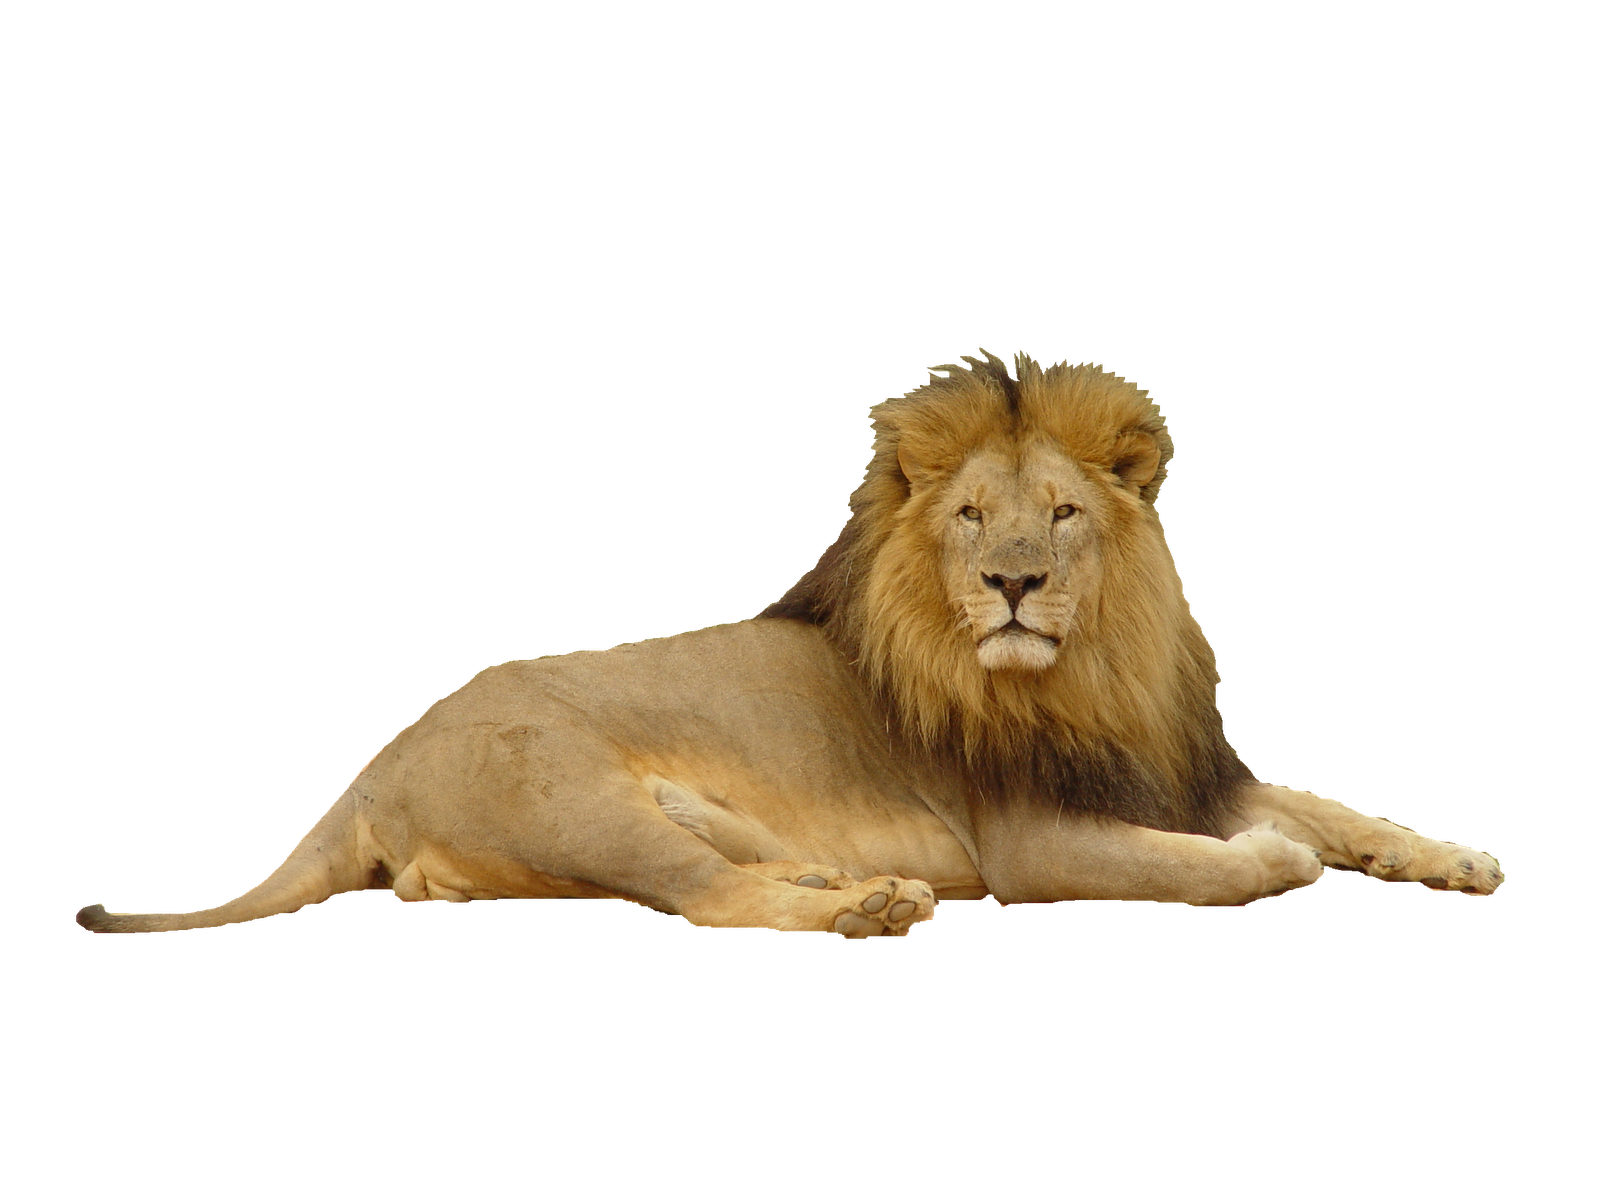

In [10]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/
from PIL import Image
Image.open('./png/example2.png')

In [14]:
!python sample.py --image=./png/example2.png

<start> a brown and white dog with a red bow tie . <end>


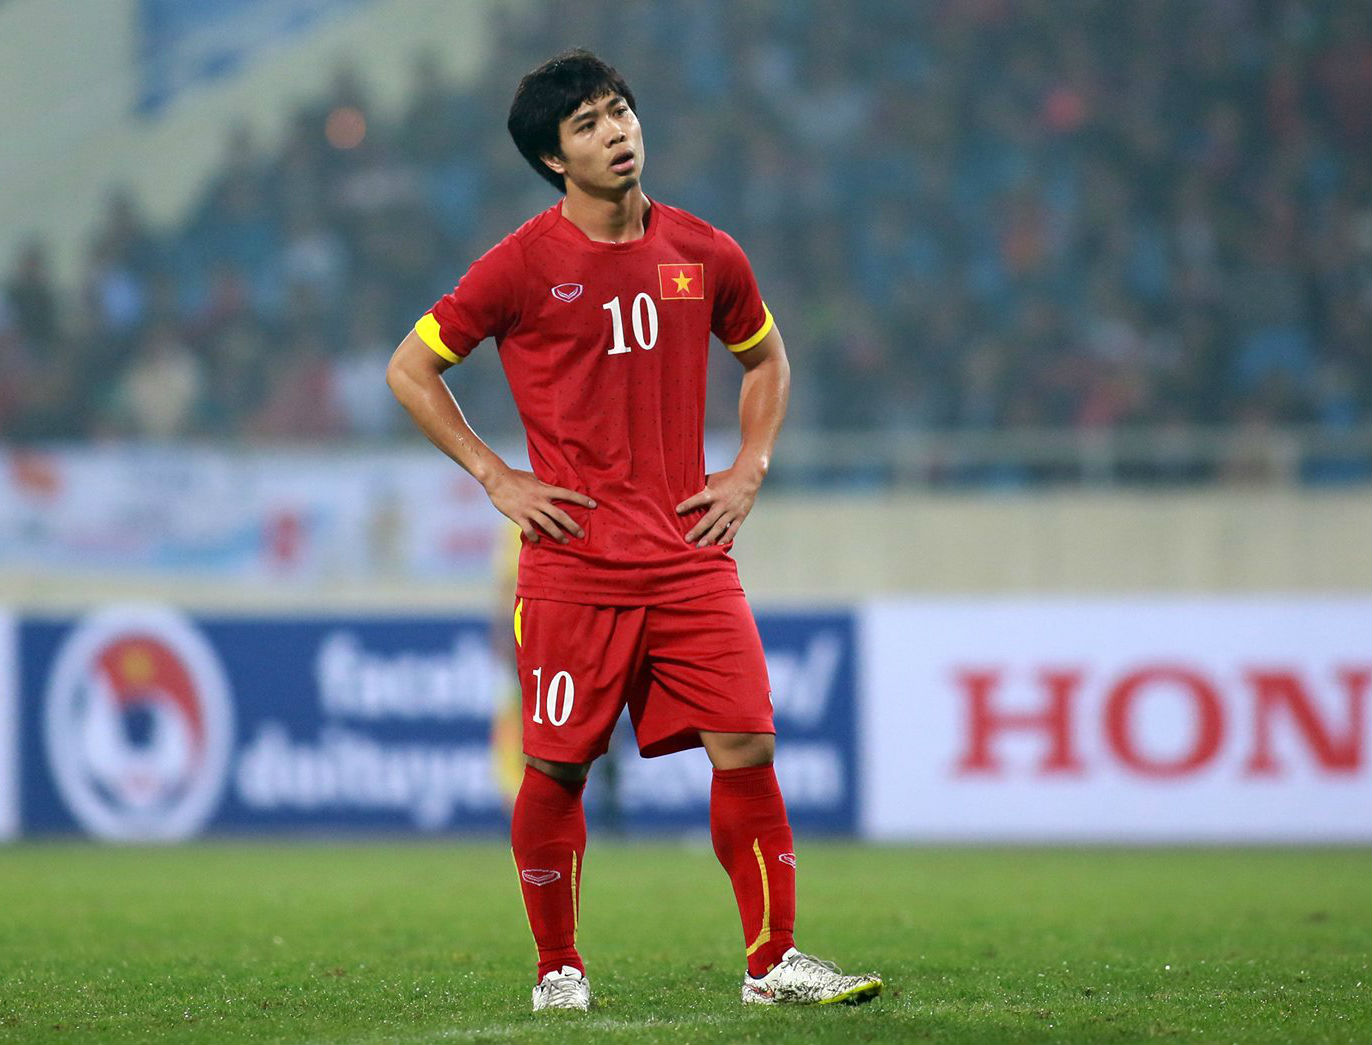

In [17]:
Image.open('./png/example3.png')

In [19]:
!python sample.py --image=./png/example3.png

<start> a man is playing a game of baseball . <end>


Well, not quite exactly.

## Problem 3 & 4 - I decided to skip it 

-----------------------------------------------------------------------------------------------------------------------------------------

This is the end of my assignment, thank you for reading!